In [1]:
import pandas as pd
import torch
from chronos import BaseChronosPipeline
import tqdm as notebook_tqdm

import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')
import pdb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5
TEST_BEGIN = '2021.04.06'
TEST_END = '2021.06.01'
TRAIN_BEGIN = '2018.03.30'
TRAIN_END = '2021.04.05'
TIMES = 10

In [3]:
df = pd.read_csv('../Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

df 
df.tail(290)

,date,open,high,low,close
1049,2020.03.31,13.16,14.07,13.16,13.54
1050,2020.04.01,13.01,14.08,12.89,13.84
1051,2020.04.02,14.90,16.01,14.52,15.01
1052,2020.04.03,15.77,15.83,14.44,14.84
1053,2020.04.06,15.53,15.58,14.69,15.26
...,...,...,...,...,...
1334,2021.05.26,25.91,26.18,25.65,26.09
1335,2021.05.27,26.08,26.25,25.77,25.91
1336,2021.05.28,26.20,27.02,26.15,26.99
1337,2021.05.31,26.96,27.20,26.78,26.87


In [9]:
def create_df(fundo):
    df = pd.read_csv(f'../Data/{fundo}_Daily.csv', sep = "\t")
    df.columns = dfColumns
    df = removeColumns(df, ['tickvol', 'volume','spread'])
    df = calculateEMA(df,DAYS,newColumns)
    df = calculateBB(df,DAYS,newColumns)
    df = addPreviousDays(df,DAYS, newColumns)
    initialDf_ = getPeriod(df, '2017.06.01','2021.06.01', True)
    return initialDf_

In [10]:
pd.set_option('display.max_columns', None)
df = create_df('PETR4')

In [11]:
df

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,LB_open,UB_high,LB_high,UB_low,LB_low,UB_close,LB_close,d-1_open,d-1_high,d-1_low,d-1_close,d-2_open,d-2_high,d-2_low,d-2_close,d-3_open,d-3_high,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2017.06.01,11.94,12.05,11.63,11.63,12.136793,12.273017,11.924555,11.967413,12.512389,11.791611,12.745750,11.850250,12.553403,11.422597,12.728339,11.359661,11.98,12.07,11.75,11.75,12.29,12.37,12.12,12.12,12.33,12.49,12.29,12.31,12.22,12.51,12.15,12.41,12.67,12.87,12.36,12.46
1,2017.06.02,11.60,11.84,11.50,11.84,11.957862,12.128678,11.783037,11.924942,12.622205,11.433795,12.688900,11.639100,12.526640,11.189360,12.487674,11.372326,11.94,12.05,11.63,11.63,11.98,12.07,11.75,11.75,12.29,12.37,12.12,12.12,12.33,12.49,12.29,12.31,12.22,12.51,12.15,12.41
2,2017.06.05,11.75,12.01,11.72,11.95,11.888575,12.089118,11.762024,11.933295,12.433421,11.390579,12.451249,11.684751,12.207163,11.280837,12.233606,11.482394,11.60,11.84,11.50,11.84,11.94,12.05,11.63,11.63,11.98,12.07,11.75,11.75,12.29,12.37,12.12,12.12,12.33,12.49,12.29,12.31
3,2017.06.06,12.00,12.09,11.82,11.95,11.925717,12.089412,11.781350,11.938863,12.200295,11.507705,12.213196,11.810804,11.930820,11.437180,12.098080,11.549920,11.75,12.01,11.72,11.95,11.60,11.84,11.50,11.84,11.94,12.05,11.63,11.63,11.98,12.07,11.75,11.75,12.29,12.37,12.12,12.12
4,2017.06.07,12.04,12.10,11.62,11.67,11.963811,12.092942,11.727566,11.849242,12.237376,11.494624,12.229376,11.806624,11.897332,11.418668,12.111447,11.504553,12.00,12.09,11.82,11.95,11.75,12.01,11.72,11.95,11.60,11.84,11.50,11.84,11.94,12.05,11.63,11.63,11.98,12.07,11.75,11.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,2021.05.26,25.91,26.18,25.65,26.09,26.114791,26.354219,25.760657,26.042263,26.608719,25.751281,26.745428,26.018572,26.105344,25.526656,26.470349,25.609651,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15
984,2021.05.27,26.08,26.25,25.77,25.91,26.103194,26.319479,25.763771,25.998175,26.604087,25.727913,26.748720,26.003280,26.101899,25.550101,26.471798,25.600202,25.91,26.18,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93
985,2021.05.28,26.20,27.02,26.15,26.99,26.135462,26.552986,25.892514,26.328784,26.617551,25.762449,27.187686,25.848314,26.267099,25.468901,27.180120,25.307880,26.08,26.25,25.77,25.91,25.91,26.18,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95
986,2021.05.31,26.96,27.20,26.78,26.87,26.410308,26.768657,26.188343,26.509189,27.147657,25.504343,27.560157,25.747843,26.948670,25.103330,27.435810,25.244190,26.20,27.02,26.15,26.99,26.08,26.25,25.77,25.91,25.91,26.18,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39


In [12]:
df.shape

(988, 37)

In [26]:
def exp_chronos(df, target_col='high', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01',
                prediction_length=5):

    # 1. Separar os períodos
    df_train = getPeriod(df, train_start, train_end)
    df_valid = getPeriod(df, valid_start, valid_end)
    df_test  = getPeriod(df, test_start, test_end)

    # 2. Selecionar a série alvo
    y_train = df_train[target_col].values
    y_valid = df_valid[target_col].values
    y_test  = df_test[target_col].values

    # 3. Preparar entrada para Chronos
    serie_torch = torch.tensor(np.concatenate([y_train, y_valid]), dtype=torch.float32)
    
    pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-t5-small", device_map="auto")
    quantiles, mean = pipeline.predict_quantiles(
        context=serie_torch,
        prediction_length=prediction_length,
        quantile_levels=[0.1, 0.5, 0.9]
    )

    #4.Resultados
    y_pred_mean = mean[0].numpy()
    y_test_orig = y_test[-prediction_length:]
    q10 = quantiles[0, :, 0].numpy()
    q90 = quantiles[0, :, 2].numpy()
    uncertainty = q90 - q10


    return [y_test_orig, y_pred_mean, uncertainty]

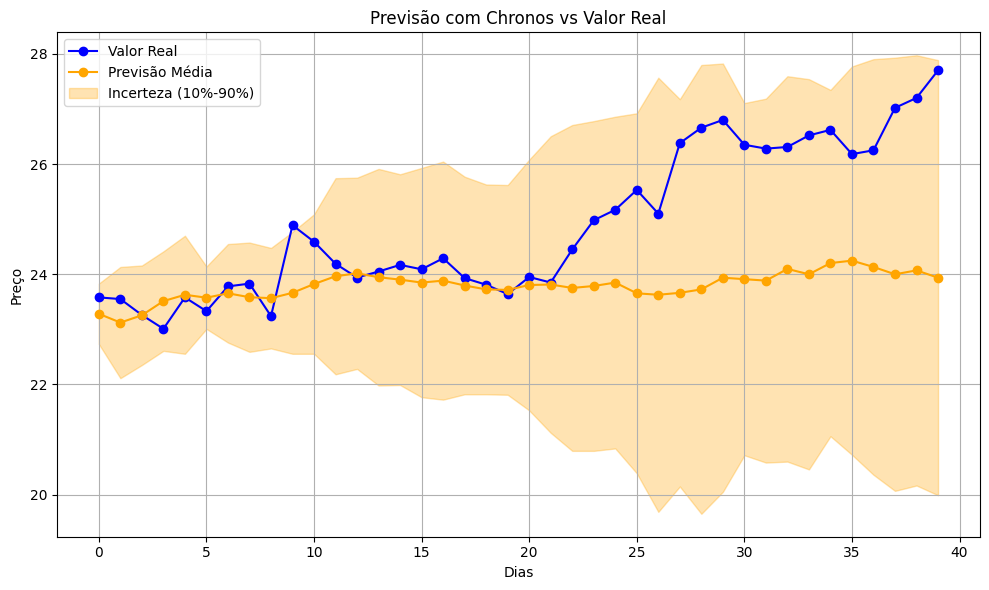

In [28]:
y_test_orig, y_pred_mean, uncertainty = exp_chronos(df, prediction_length=40)

# Criar eixo de tempo
dias = np.arange(len(y_test_orig))

# Calcular faixa de incerteza (intervalo 90% - 10%)
inferior = y_pred_mean - (uncertainty / 2)
superior = y_pred_mean + (uncertainty / 2)

plt.figure(figsize=(10, 6))

# Linha real (azul)
plt.plot(dias, y_test_orig, label='Valor Real', color='blue', marker='o')

# Linha prevista (laranja)
plt.plot(dias, y_pred_mean, label='Previsão Média', color='orange', marker='o')

# Faixa de incerteza (sombreada)
plt.fill_between(dias, inferior, superior, color='orange', alpha=0.3, label='Incerteza (10%-90%)')

# Rótulos e legendas
plt.title('Previsão com Chronos vs Valor Real')
plt.xlabel('Dias')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Fine tuning?**

In [29]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [30]:
print(df.head(10))

         date   open   high    low  close   EMA_open   EMA_high    EMA_low  \
0  2017.06.01  11.94  12.05  11.63  11.63  12.136793  12.273017  11.924555   
1  2017.06.02  11.60  11.84  11.50  11.84  11.957862  12.128678  11.783037   
2  2017.06.05  11.75  12.01  11.72  11.95  11.888575  12.089118  11.762024   
3  2017.06.06  12.00  12.09  11.82  11.95  11.925717  12.089412  11.781350   
4  2017.06.07  12.04  12.10  11.62  11.67  11.963811  12.092942  11.727566   
5  2017.06.08  11.59  11.75  11.53  11.65  11.839207  11.978628  11.661711   
6  2017.06.09  11.75  11.88  11.64  11.65  11.809472  11.945752  11.654474   
7  2017.06.12  11.76  11.82  11.58  11.70  11.792981  11.903835  11.629649   
8  2017.06.13  11.75  11.81  11.58  11.74  11.778654  11.872556  11.613100   
9  2017.06.14  11.74  11.83  11.44  11.45  11.765769  11.858371  11.555400   

   EMA_close    UB_open    LB_open    UB_high    LB_high     UB_low  \
0  11.967413  12.512389  11.791611  12.745750  11.850250  12.553403   

In [179]:
def getTrainDf(df_train, target_col='high'):
    removed_col = 'low' if target_col == 'high' else 'high'

    df_train = df_train.copy()
    df_train['item_id'] = 'ASSET'
    df_train = df_train.drop([removed_col, 'close'], axis=1)
    df_train = df_train.rename(columns={'date': 'timestamp'})
    df_train.columns = [col for col in df_train.columns]
    return TimeSeriesDataFrame(df_train)

In [180]:
def getTestDf(df):
    df_test = df.copy()
    df_test['item_id'] = 'ASSET'
    df_test = df_test.drop(['high', 'low', 'close'], axis=1)
    df_test = df_test.rename(columns={'date': 'timestamp'})
    df_test.columns = [col for col in df_test.columns]

    return TimeSeriesDataFrame(df_test)


In [181]:
def fixHoliday(df):
    df_ts = df.reset_index()
    nova_linha = df_ts.iloc[10]
    nova_linha['timestamp'] = pd.Timestamp('2021-04-21')
    df_ts = pd.concat([df_ts.iloc[:11], pd.DataFrame([nova_linha]), df_ts.iloc[11:]], ignore_index=True)
    return TimeSeriesDataFrame(df_ts)

In [182]:
def generatePredictor(df, target_col='high', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01',
                prediction_length=5):

    df_train = getPeriod(df, train_start, train_end)
    df_valid = getPeriod(df, valid_start, valid_end)

    train_df = getTrainDf(pd.concat([df_train, df_valid]), target_col=target_col)

    predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        target=target_col,
        known_covariates_names=[col for col in train_df.columns if col not in ['item_id', 'timestamp', target_col]],
        freq="B"
    ).fit(
        train_df,
        hyperparameters={
            "Chronos": [
                {
                    "model_path": "bolt_small",
                    "covariate_regressor": "CAT",
                    "target_scaler": "standard",
                    "ag_args": {"name_suffix": "WithRegressor"},
                },
            ],
        },
        enable_ensemble=False,
        time_limit=None,
    )

    return predictor
           

In [204]:
def exp_chronos_with_finetuning(df, predictor, target_col='high', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01'):
    
    df_train = getPeriod(df, train_start, train_end)
    df_valid = getPeriod(df, valid_start, valid_end)
    df_test  = getPeriod(df, test_start, test_end)

    y_test  = df_test[target_col].values

    inputDf = getTrainDf(pd.concat([df_train, df_valid]), target_col=target_col)
    covariates_df = getTestDf(df_test)
    covariates_df = fixHoliday(covariates_df)   
    forecast = predictor.predict(inputDf, known_covariates=covariates_df)

    #4.Resultados
    y_pred_mean = forecast['mean']
    y_test_orig = y_test[-40:]
    q10 = forecast['0.1']
    q90 = forecast['0.9']
    uncertainty = q90 - q10


    return [y_test_orig, y_pred_mean, uncertainty]

In [201]:
def generatePlot(df, predictor, target_col): 
    y_test_orig, y_pred_mean, uncertainty = exp_chronos_with_finetuning(df, predictor, target_col=target_col)

    y_pred_mean = y_pred_mean.drop(y_pred_mean.index[11])
    uncertainty = uncertainty.drop(uncertainty.index[11])

    # Criar eixo de tempo
    dias = np.arange(len(y_test_orig))

    # Calcular faixa de incerteza (intervalo 90% - 10%)
    inferior = y_pred_mean - (uncertainty / 2)
    superior = y_pred_mean + (uncertainty / 2)

    plt.figure(figsize=(10, 6))

    # Linha real (azul)
    plt.plot(dias, y_test_orig, label='Valor Real', color='blue', marker='o')

    # Linha prevista (laranja)
    plt.plot(dias, y_pred_mean, label='Previsão Média', color='red', marker='o')

    # Faixa de incerteza (sombreada)
    plt.fill_between(dias, inferior, superior, color='orange', alpha=0.3, label='Incerteza (10%-90%)')

    # Rótulos e legendas
    plt.title('Previsão com Chronos vs Valor Real')
    plt.xlabel('Dias')
    plt.ylabel('Preço (' + target_col + ')')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [185]:
high_predictor = generatePredictor(df, prediction_length=41, target_col='high')

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Rodrigo\Desktop\TCC\Code\DayTradeSystem\DayTradeSystem\Rodrigo\AutogluonModels\ag-20250608_154704'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       19.11 GB / 31.94 GB (59.8%)
Disk Space Avail:   229.07 GB / 446.38 GB (51.3%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['open',
                            'EMA_open',
                            'EMA_high',
                      

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: ChronosWithRegressor[bolt_small]


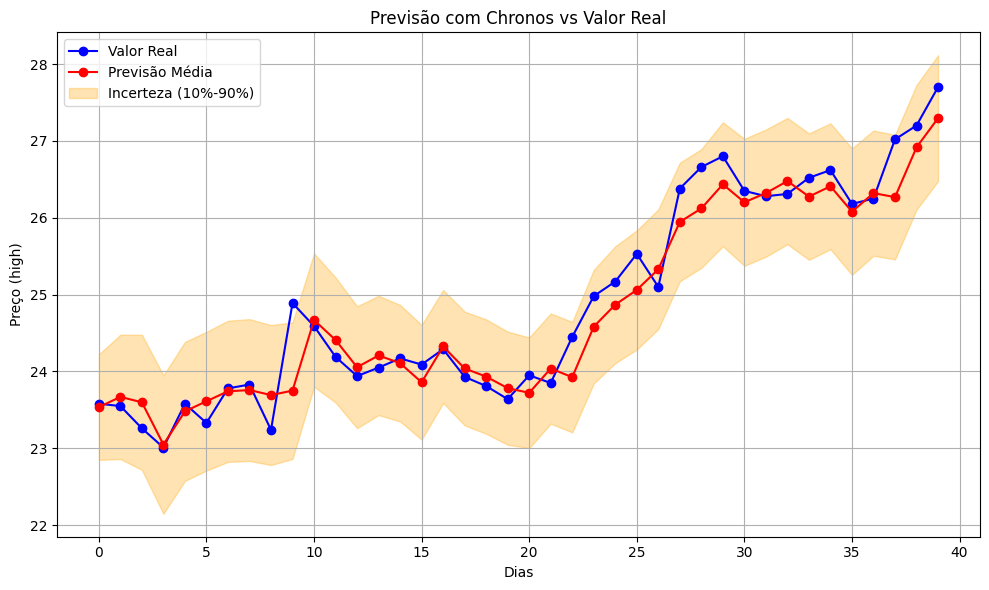

In [205]:
generatePlot(df, high_predictor, 'high')

In [187]:
low_predictor = generatePredictor(df, prediction_length=41, target_col='low')

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Rodrigo\Desktop\TCC\Code\DayTradeSystem\DayTradeSystem\Rodrigo\AutogluonModels\ag-20250608_154959'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       18.92 GB / 31.94 GB (59.2%)
Disk Space Avail:   229.06 GB / 446.38 GB (51.3%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['open',
                            'EMA_open',
                            'EMA_high',
                      

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: ChronosWithRegressor[bolt_small]


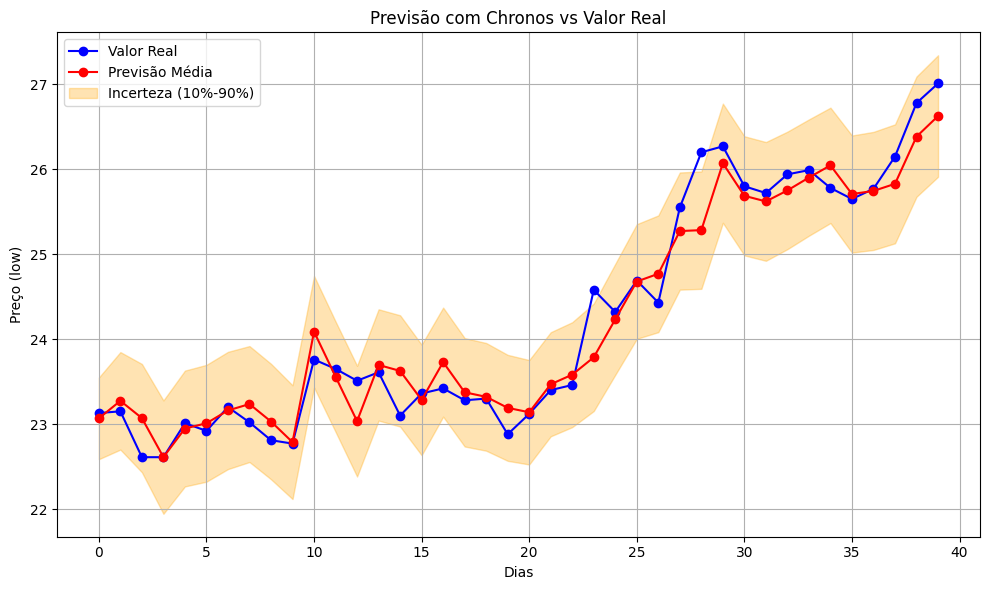

In [206]:
generatePlot(df, low_predictor, 'low')